In [1]:
# 시각화
import plotly.express as px
from IPython.core.display import HTML
from IPython.display import Image
# mongodb
import pymongo
import os
from dotenv import load_dotenv
#기타
import pandas as pd
from tqdm import tqdm
import numpy as np

In [2]:
# mongodb key
load_dotenv()
mongoadress = os.environ['MONGODB_KEY']
client = pymongo.MongoClient(mongoadress)
db = client.drama

In [3]:
# insert image to dataframe
def path_to_image_html(path):
    return '<img src="'+ path + '" width="60" >'

In [4]:
def split_character(df):
    columns = ['제목','시청연령','평균 시청률','편성채널','방영정보','프로그램 소개','제작진']

    temp_df = df.등장인물.apply(pd.Series).merge(df, left_index=True, right_index=True)\
    .drop(["등장인물"], axis=1).melt(id_vars=columns, value_name="등장인물").drop(['variable'],axis=1)

    temp_df.dropna(inplace=True)

    result_df = pd.concat([temp_df.drop('등장인물',axis=1),temp_df.등장인물.apply(pd.Series)],axis=1)
    return result_df

In [5]:
# mongodb query
find_query = {'_id':0,
              '제목':1,
              '제작진':1,
              '시청연령':1,
              '평균 시청률':1,
              '편성채널':1,
              '방영정보.방영기간':1,
              '프로그램 소개':1,
              '등장인물':1
}

condition_query = {
    '평균 시청률':{'$ne':None},
    '장르':{'$eq':'드라마'}
}

In [6]:
# make cusor
end_cusor = db.end_drama_phome_data.find(condition_query,find_query)
ing_cusor = db.require_update_phome_data.find(condition_query,find_query)
no_cusor = db.no_p_home_data.find(condition_query,find_query)

In [7]:
# make dateframe
end_df = pd.DataFrame(list(end_cusor))
ing_df = pd.DataFrame(list(ing_cusor))
no_df = pd.DataFrame(list(no_cusor))

In [8]:
# split chracter and make dateframe
mod_end_df = split_character(end_df)
mod_ing_df = split_character(ing_df)
mod_no_df = split_character(no_df)

In [9]:
# merge dataframe
total_df = mod_end_df.append(mod_ing_df,ignore_index=True)
total_df = total_df.append(mod_no_df,ignore_index=True).drop(['배역 url'],axis=1)
total_df = total_df.rename(columns={'평균 시청률':'평균시청률'})

In [10]:
### scrape actor image from website **when not exist image in database
# from IPython.core.display import HTML
# import requests
# from bs4 import BeautifulSoup as bs

# actor_pic = []
# for i in total_df['배우 url']:
#     if i is not None:
#         url = i
#         req = requests.get(url)
#         html = req.text
#         soup = bs(html,'lxml')
#         if soup.find('div',{'class':'big_thumb'})is not None:
#             img = soup.find('div',{'class':'big_thumb'}).find('img')
            
#             if 'src' in img.attrs:
#                 actor_pic.append(img.attrs['src'])
#             else:
#                 actor_pic.append(None)
            
#         else:
#             actor_pic.append(None)
#     else:
#         actor_pic.append(None)
        
# total_df['actor_pic'] = actor_pic

In [11]:
total_df_img_added = pd.read_csv('data/actor_imgurl_added.csv',encoding='utf-8',sep=',')

In [12]:
total_df_img_added.drop(['배우 url','나이','직업'],axis=1,inplace=True)

# ??? 배우 출연하면 시청률 보장?! <br><br> 시청률 보증 수표 배우 찾기

이번 스토리에서는 나오기만하면 드라마의 인기를 빵빵 터트리는<p>
'히트 제조기', '흥행 보증 수표', '믿보배'(~~믿고 보는 배우~~) 를 찾아 보겠다.

mongodb에 저장된 데이터를 불러와서 가공한 뒤<p>
배우 출연작의 (평균)시청률을 평균내어 나열 해 봤다.

----

## 목차

[출연작의 평균](#mean)

[새로운 기준](#new)

[출연작이 3개이상](#more)

[문제점](#problem)

[결론](#result)

[부록](#add)

----

## 들어가기 앞서

들어가기에 앞서서 내가 생각하는 믿보배를 뽑아봤다.<p>
로맨틱코미드 장르의 **공효진**<p>

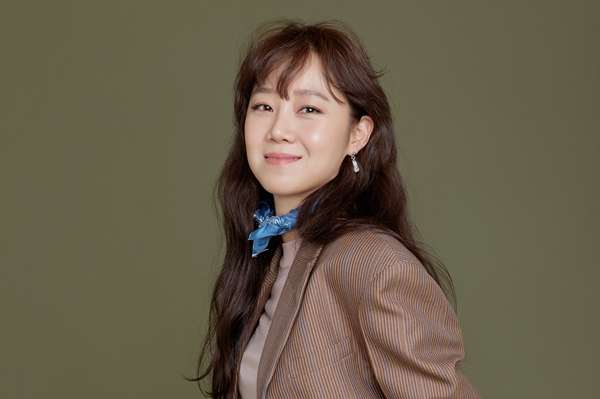

In [13]:
Image('img/hyojin.jpeg',width=300,height=50)

주말 드라마의 강자 **이장우**<p>

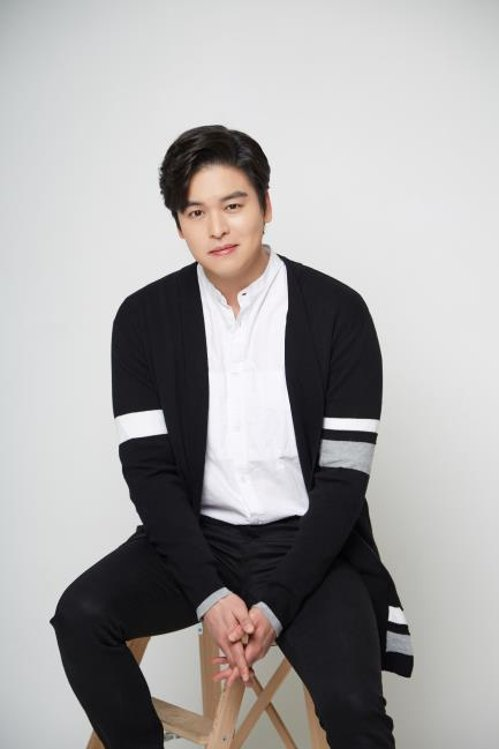

In [14]:
Image('img/leejang.jpeg',width=200,height=10)

그냥 **송중기**<p>

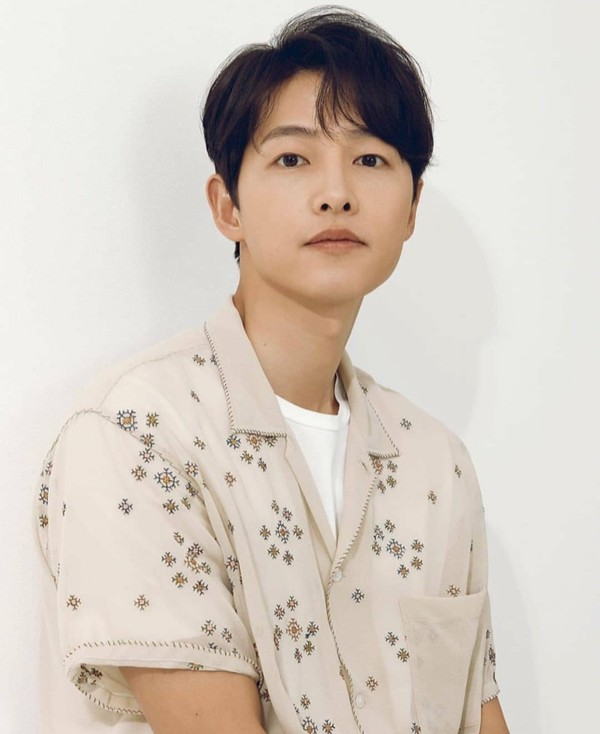

In [15]:
Image('img/song.jpeg',width=200,height=10)

조연으로 나오면 빵빵 **김병철**<p>

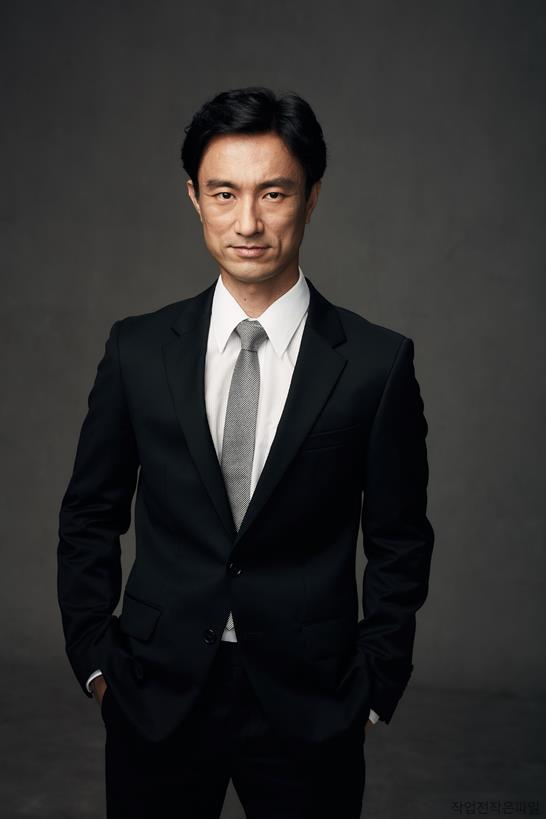

In [16]:
Image('img/kim.jpeg',width=200,height=10)

실장님 **박재정**<p>

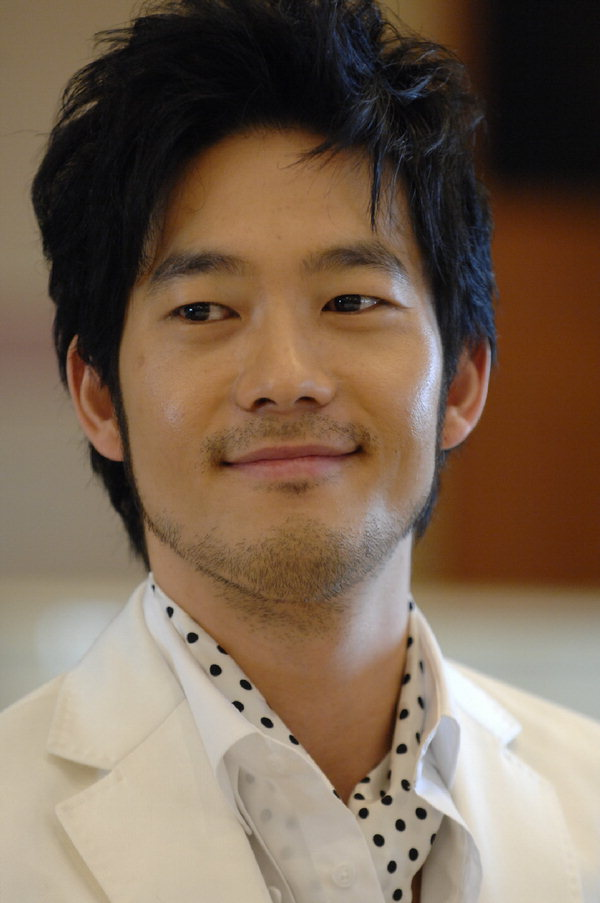

In [17]:
Image('img/park.jpg',width=200,height=10)

(~~여러분이 생각하는 흥행 보증수표는 누가 있나요~~)

----

## 출연작의 평균

<font size="0.5"><a id='mean'>깃발</a></font>

In [18]:
total_df.groupby('배우').mean().query("평균시청률>10").sort_values('평균시청률',ascending=False)

평균시청률
배우            
임소영  49.700000
이상구  49.400000
김추월  49.400000
박용진  49.300000
김경희  48.300000
..         ...
서현진  10.033333
정규수  10.025000
이채미  10.022222
임윤호  10.016667
이호재  10.008333

[2422 rows x 1 columns]

출연작 평균 시청률이 40%가 넘는 사람들이 많다..😲<br>
이분들이 바로 흥행보증수표..?!<br><p>
    
아니.😐<br><p>
    
데이터를 자세히 들여다 보면 다음과 같다.

In [19]:
pd.set_option("display.max_colwidth", None)

In [20]:
im_df = total_df_img_added.query("배우=='임소영'")[['제목','평균시청률','배우','배역','인물묘사','actor_pic']]
kim_df = total_df_img_added.query("배우=='김추월'")[['제목','평균시청률','배우','배역','인물묘사','actor_pic']]

In [21]:
HTML(im_df.to_html(escape=False,formatters=dict(actor_pic=path_to_image_html)))

In [22]:
HTML(kim_df.to_html(escape=False,formatters=dict(actor_pic=path_to_image_html)))

상위의 두분만 살펴봐도 <p>
출연작의 시청률 평균은 '히트 제조기'의 기준이 될 수 없다.<p>
흔히 로맨스코미디 장르의 '흥행 보증 수표'라고 불리는 공효진 배우의 평균 점수를 보자.

```
print('공효진 배우 출연작 시청률 평균 : %.1f'%(total_df.query("배우=='공효진'")['평균시청률'].mean()))
```

In [23]:
print('공효진 배우 출연작 시청률 평균 : %.1f'%(total_df.query("배우=='공효진'")['평균시청률'].mean()))

공효진 배우 출연작 시청률 평균 : 18.8


역시 기준을 새로 세워야한다. 🤔

----

## 새로운 기준

<font size="0.5"><a id='new'>깃발</a></font>

새로운 기준으로 출연 작품 수가 3편 이상인 배우 중에서 <p>
작품 수 대비 시청률이 ??% 이상인 작품의 수를 비율로써 나타내겠다.<p>
그리고 이를 **믿볼확** (~~믿고 볼 확률~~)이라고 하겠다.

먼저 믿볼확을 구하기 전에 ??% 이상의 시청률을 구하기 위해<p>
??% 를 정해야한다.

**스토리의 작성자인 나의 기준에서**<p>
**지상파** ( KBS, MBC, SBS )**에서는 15%이상**<p>
**케이블** ( 이외의 방송사 )**에서는 10%이상으로 하겠다.** ( tvN 빈센조 - 14%, SBS 모범택시 - 16% )<p>

(~~시청률 기준 이 마음에 안드시는 분께서는 댓글을 달아주세요~~)

----

## 출연작이 3개 이상

<font size="0.5"><a id='new'>깃발</a></font>

먼저 출연작이 3작품 이상인 배우부터 살펴보자.

In [24]:
total_df_img_added['배우'].value_counts()[total_df_img_added['배우'].value_counts()>=3]

안내상    62
김희정    47
이준혁    43
엄효섭    43
이한위    39
       ..
하성광     3
솔비      3
추예진     3
이재준     3
정종준     3
Name: 배우, Length: 2243, dtype: int64

In [25]:
count_dict = dict(total_df_img_added['배우'].value_counts()[total_df_img_added['배우'].value_counts()>=3])

다음으로 3작품 이상인 배우들의<p>
지상파 시청률 15%이상 조건과 케이블 시청률 10%이상인 작품들만 뽑는 쿼리를 작성하고

```python
dataframe_query = """
(배우==@i) and ((((편성채널 in ['KBS','SBS','MBC','KBS2']) and (평균시청률>=15)) or ((편성채널 not in ['KBS','SBS','MBC','KBS2']) and (평균시청률>=10))))
"""  
```

In [26]:
# dataframe query
dataframe_query = """
(배우==@i) and ((((편성채널 in ['KBS','SBS','MBC','KBS2']) and (평균시청률>=15)) or ((편성채널 not in ['KBS','SBS','MBC','KBS2']) and (평균시청률>=10))))
"""  

(조건에 만족하는 작품 수 / 배우의 총 작품 수) 를 구했다.<P>
    
상위 5명, 하위 5명을 뽑아본 결과는 다음과 같다.

In [27]:
mbh = pd.DataFrame(columns=['배우','믿볼확','actor_pic'])

for i, v in count_dict.items():
    mbh = mbh.append({
        '배우':i,
        '믿볼확':round((len(total_df_img_added.query(dataframe_query))/v),2),
        'actor_pic':total_df_img_added.query("배우==@i").reset_index().iloc[0]['actor_pic']},ignore_index=True)

In [28]:
# mbh.sort_values('믿볼확',ascending=False)
HTML(mbh.sort_values('믿볼확',ascending=False).iloc[np.r_[0:5,-5:0]].to_html(escape=False,formatters=dict(actor_pic=path_to_image_html)))

여기서 내가 생각한 흥행 보증 수표 배우들의 값을 뽑아 보자.

In [29]:
HTML(mbh.query("배우=='공효진'").to_html(escape=False,formatters=dict(actor_pic=path_to_image_html)))

In [30]:
HTML(mbh.query("배우=='송중기'").to_html(escape=False,formatters=dict(actor_pic=path_to_image_html)))

In [31]:
HTML(mbh.query("배우=='박재정'").to_html(escape=False,formatters=dict(actor_pic=path_to_image_html)))

In [32]:
HTML(mbh.query("배우=='김병철'").to_html(escape=False,formatters=dict(actor_pic=path_to_image_html)))

공효진 배우는 71%의 확률로 출연작이 흥행 할 것이고....<p>
박재정, 김병철 배우는 50%확률로... 반반?<p>
송중기 배우는 44%확률이다.<br><br>

이 지표가 의미가 있을까?<p>
공효진, 송중기 배우가 위의 100%확률의 배우들보다 출연작을 히트 시킬 확률이 적단 말인가<br><br>
    
이 지표는 현실적으로 흥행 보증 수표를 뽑기에는 다소 무리가 있어 보인다.<p>
좀 더 구체적인 정보와 조건을 설정 할 필요가 있다. ( 예를들면 데이터의 부재, 주연인지 조연인지, 시작 시점...)

----

## 문제점

<font size="0.5"><a id='problem'>깃발</a></font>

데이터를 보면서 이 지표의 문제점을 살표보자<p>
**먼저 수집한 데이터가 부족하다**<p>
오래된 드라마는 수집 목록에 포함되지 못했다.<br><br>

전통강호 **이병헌** 배우로 확인해보자.

In [33]:
HTML(total_df_img_added.query("배우=='이병헌'").to_html(escape=False,formatters=dict(actor_pic=path_to_image_html)))

여기다 드라마 올인까지 하면 작품 수가 3개 이상으로 믿보배에 들어갔을 것 인데<p>
드라마 올인 데이터의 부재로 고려 대상에서 아예 제외가 되었다.

다음으로 **흥행 드라마 기준을 선정하는데 어려움**이 있다.<P>
이는 드라마 '사이코지만 괜찮아'로 확인해보자

In [34]:
HTML(total_df_img_added.query("제목=='사이코지만 괜찮아'")[:1].to_html(escape=False,formatters=dict(actor_pic=path_to_image_html)))

이 드라마의 경우 화제성도 좋았고, 직접 보지는 않았지만<p>
주변 반응이 좋았기 때문에 흥행 했다고 생각한다. 하지만 이번 지표에는 포함되지 못했다.

마지막으로 **동명이인 배우로 인한 데이터 잡음**이다.

In [35]:
# total_df.query("배우=='김수현'")


fig = px.bar(total_df.query("배우=='김수현'").sort_values(['평균시청률']), x='제목', y='평균시청률',title='김수현', template='simple_white')
fig.update_yaxes(range=[0, 50])
fig.update_xaxes(title=None)

fig.add_layout_image(
    dict(
        source="img/로고.png",
        xref="paper", yref="paper",
        x=1, y=1.05,
        sizex=0.2, sizey=0.2,
        xanchor="right", yanchor="bottom"
    )
)

fig.show()

드라마 '그녀의 신화', '땐뽀걸즈', '그녀의 신화' 등을 보면 낮은 시청률을 가지고 있다.<p>
여기에 출연한 김수현 배우는 다른 동명이인 김수현이다.<p>
이 드라마들의 시청률이<p>
꽤 흥행 드라마가 많은 남성 성인 배우 김수현의 데이터에 잡음이 되었다.<p>
이는 주·조연 데이터가 없다는 문제점과도 일맥상통한다.

----

## 결론

<font size="0.5"><a id='result'>깃발</a></font>

부족한 지표였지만 시도는 해볼만했다고 생각한다.<p>
좀 더 업그레이드된 지표를 생각해 보겠다.

----

## 부록

<font size="0.5"><a id='add'>깃발</a></font>

[내 생각 믿보배의 출연작](#mywork) <p>
[내 생각 믿보배의 평균 시청률](#mymean) <p>

### 내 생각 믿보배의 출연작

<font size="0.5"><a id='mywork'>깃발</a></font>

[공효진](#hyo) <p>
[송중기](#song) <p>
[이장우](#lee) <p>
[김병철](#kim)<p>
[박재정](#park)

##### 공효진

<font size="0.5"><a id='hyo'>깃발</a></font>

In [36]:
# display(total_df.query("배우=='공효진'"))


fig = px.bar(total_df.query("배우=='공효진'").sort_values(['평균시청률']), x='제목', y='평균시청률',title='공효진', template='presentation')
fig.update_yaxes(range=[0, 50])
fig.update_xaxes(title=None)
# fig.add_layout_image(
#     dict(
#         source="img/괜찮아사랑이야.jpeg",
#         x=0.02, y=12.9,
#         xref="x domain",
#         yref="y",
#         sizex=6, sizey=13,
#     )
# )


# fig.add_layout_image(
#     dict(
#         source="img/질투의화신.jpeg",
#         x=0.155, y=13.2,
#         xref="x domain",
#         yref="y",
#         sizex=4, sizey=15,
#     )
# )


# fig.add_layout_image(
#     dict(
#         source="img/프로듀사.jpeg",
#         x=0.28, y=17.7,
#         xref="x domain",
#         yref="y",
#         sizex=4, sizey=17.7,
#     )
# )


# fig.add_layout_image(
#     dict(
#         source="img/최고의 사랑.jpeg",
#         x=0.42, y=21,
#         xref="x domain",
#         yref="y",
#         sizex=4, sizey=21,
#     )
# )

# fig.add_layout_image(
#     dict(
#         source="img/파스타.jpeg",
#         x=0.58, y=21.2,
#         xref="x domain",
#         yref="y",
#         sizex=4, sizey=21.2,
#     )
# )

# fig.add_layout_image(
#     dict(
#         source="img/주군의 태양.jpeg",
#         x=0.71, y=21.8,
#         xref="x domain",
#         yref="y",
#         sizex=4, sizey=21.8,
#     )
# )

# fig.add_layout_image(
#     dict(
#         source="img/동백.jpeg",
#         x=0.82, y=23.8,
#         xref="x domain",
#         yref="y",
#         sizex=4, sizey=23.8,
#     )
# )

fig.add_layout_image(
    dict(
        source="img/로고.png",
        xref="paper", yref="paper",
        x=1, y=1.05,
        sizex=0.2, sizey=0.2,
        xanchor="right", yanchor="bottom"
    )
)


fig.show()

##### 이장우

<font size="0.5"><a id='lee'>깃발</a></font>

In [37]:
# display(total_df.query("배우=='이장우'"))

fig = px.bar(total_df.query("배우=='이장우'").sort_values(['평균시청률']), x='제목', y='평균시청률',title='이장우', template='presentation')
fig.add_layout_image(
    dict(
        source="img/로고.png",
        xref="paper", yref="paper",
        x=1, y=1.05,
        sizex=0.2, sizey=0.2,
        xanchor="right", yanchor="bottom"
    )
)
fig.update_xaxes(title=None)
fig.update_yaxes(range=[0, 50])
fig.show()

##### 김병철

<font size="0.5"><a id='lee'>깃발</a></font>

In [38]:
# display(total_df.query("배우=='김병철'"))

fig = px.bar(total_df.query("배우=='김병철'").sort_values(['평균시청률']), x='제목', y='평균시청률',title='김병철', template='presentation')

fig.add_layout_image(
    dict(
        source="img/로고.png",
        xref="paper", yref="paper",
        x=1, y=1.05,
        sizex=0.2, sizey=0.2,
        xanchor="right", yanchor="bottom"
    )
)
fig.update_xaxes(title=None)
fig.update_yaxes(range=[0, 50])
fig.show()

##### 박재정

<font size="0.5"><a id='park'>깃발</a></font>

In [39]:
# display(total_df.query("배우=='박재정'"))

fig = px.bar(total_df.query("배우=='박재정'").sort_values(['평균시청률']), x='제목', y='평균시청률',title='박재정', template='presentation')

fig.add_layout_image(
    dict(
        source="img/로고.png",
        xref="paper", yref="paper",
        x=1, y=1.05,
        sizex=0.2, sizey=0.2,
        xanchor="right", yanchor="bottom"
    )
)
fig.update_xaxes(title=None)
fig.update_yaxes(range=[0, 50])
fig.show()

##### 송중기

<font size="0.5"><a id='song'>깃발</a></font>

In [40]:
# display(total_df.query("배우=='송중기'"))

fig = px.bar(total_df.query("배우=='송중기'").sort_values(['평균시청률']), x='제목', y='평균시청률',title='송중기', template='presentation')

fig.add_layout_image(
    dict(
        source="img/로고.png",
        xref="paper", yref="paper",
        x=1, y=1.05,
        sizex=0.2, sizey=0.2,
        xanchor="right", yanchor="bottom"
    )
)
fig.update_xaxes(title=None)
fig.update_yaxes(range=[0, 50])
fig.show()

### 내 생각 믿보배의 평균 시청률

<font size="0.5"><a id='mymean'>깃발</a></font>

In [41]:
print('공효진 : %.2f'%total_df.query("배우=='공효진'")['평균시청률'].mean())

공효진 : 18.80


In [42]:
print('송중기 : %.2f'%total_df.query("배우=='송중기'")['평균시청률'].mean())

송중기 : 13.56


In [43]:
print('이장우 : %.2f'%total_df.query("배우=='이장우'")['평균시청률'].mean())

이장우 : 19.33


In [44]:
print('김병철 : %.2f'%total_df.query("배우=='김병철'")['평균시청률'].mean())

김병철 : 15.95


In [45]:
print('박재정 : %.2f'%total_df.query("배우=='박재정'")['평균시청률'].mean())

박재정 : 14.23


### 그래프에 포스터를 넣어보았다.

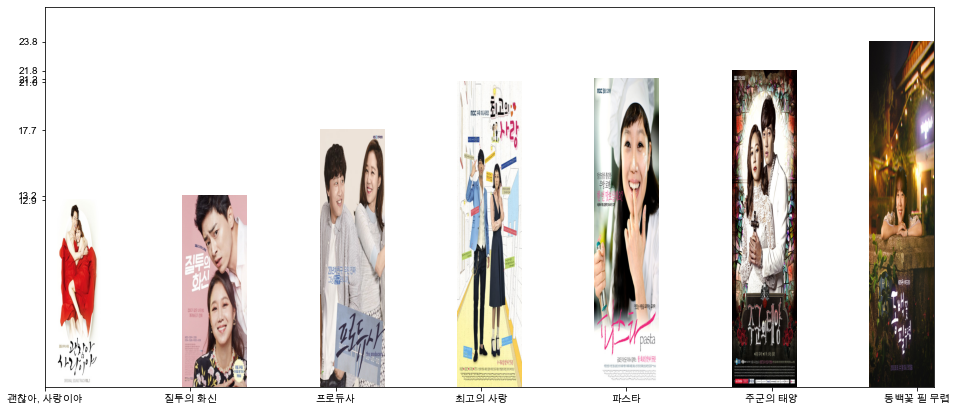

In [46]:
from imageio import imread
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
font_path = "/Library/Fonts/Arial Unicode.ttf"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)



def image_plot(heights, images, label, spacing=0):
    # Iterate through images and data, autoscaling the width to
    # the aspect ratio of the image
#     plt.figure(figsize=(15, 6))
    fig, ax = plt.subplots(1,1, figsize=(25, 7))
    
    for i, (height, img) in enumerate(zip(heights, images)):
#         AR = img.shape[1] / img.shape[0]
        width = 89000 #height * AR
        left = width*i + spacing*i
        right = left + width
        ax.imshow(img, extent=[left, right, 0, height])
    # Set x,y limits on plot window
    plt.xlim(0, right)
    plt.ylim(0,max(heights)*1.1)
    
    
    ax.set_xticklabels(label)
    ax.set_yticks(data)
    ax.set_yticklabels(('12.9', "13.2",
                    "17.7", "21.0","21.2","21.8","23.8"))
    plt.show()
    
    
data = total_df.query("배우=='공효진'")['평균시청률'].sort_values()*20000
labels = ['괜찮아, 사랑이야','질투의 화신','프로듀사','최고의 사랑','파스타','주군의 태양','동백꽃 필 무렵']
img1 = imread('img/괜찮아사랑이야.jpeg')
img2 = imread('img/질투의화신.jpeg')
img3 = imread('img/프로듀사.jpeg')
img4 = imread('img/최고의 사랑.jpeg')
img5 = imread('img/파스타.jpeg')
img6 = imread('img/주군의 태양.jpeg')
img7 = imread('img/동백.jpeg')

img = [img1,img2,img3,img4,img5,img6,img7]


image_plot(data, img, spacing=100000,label=labels)